# 模型效果
对于googlenet baseline 的修改，详细见md文件


## 对比（非lstm架构）
r2_train: 0.9947811961174011
r2_val: 0.9749422669410706
r2_a: 0.9464100454957816
r2_b: 0.6836000724611211

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from torchsummary import summary
from sklearn.model_selection import train_test_split
import shutil

'''Load data'''
temp_Qd = np.load('Data_processed/Qd_100.npy',allow_pickle=True).item()
temp_life = np.load('Data_processed/cycle_life.npy',allow_pickle=True).item()
all_capacity = np.load('Data_processed/all_capacity.npy',allow_pickle=True).item()
temp_Qd_all = []
temp_life_all = []
all_capacity_all = []

for key in temp_Qd.keys():
    temp_life_all.append(temp_life[key])
    all_capacity_all.append(all_capacity[key])
    temp_Qd_list = []
    for item in temp_Qd[key]:
        temp_Qd_list.append(item)
    temp_Qd_arr = np.asarray(temp_Qd_list)
    temp_Qd_all.append(temp_Qd_arr)
all_Qd_arr = np.asarray(temp_Qd_all)
cycle_life_arr = np.asarray(temp_life_all)    


'''Divide the dataset as the original paper stated'''
test_ind = np.hstack((np.arange(0,(41+43),2),83))
train_ind = np.arange(1,(41+43-1),2)
secondary_test_ind = np.arange(124-40,124)

all_keys = list(temp_Qd.keys())
train_keys = [all_keys[inx] for inx in train_ind]
test_keys = [all_keys[inx] for inx in test_ind]
secondary_test_keys = [all_keys[inx] for inx in secondary_test_ind]

cycle_life_arr=np.asarray(cycle_life_arr).reshape(-1,1)
max_label=np.max(cycle_life_arr)
cycle_life_arr=cycle_life_arr/max_label


train_Qds = np.asarray(all_Qd_arr)[train_ind]
train_cycle_lifes = np.asarray(cycle_life_arr)[train_ind]

test_Qd_a = np.asarray(all_Qd_arr)[test_ind]
test_cycle_life_a = np.asarray(cycle_life_arr)[test_ind]

test_Qd_b = np.asarray(all_Qd_arr)[secondary_test_ind]
test_cycle_life_b = np.asarray(cycle_life_arr)[secondary_test_ind]

train_Qd, _, train_cycle_life, _ = train_test_split(train_Qds, train_cycle_lifes, test_size=0.36, random_state=3)


In [2]:
import torch

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # 公用的前3层卷积层
        self.shared_cnn = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, kernel_size=(50, 50), stride=(5, 40)),
            torch.nn.BatchNorm2d(8),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=1),
            torch.nn.Dropout(p=0.2),
            
            torch.nn.Conv2d(8, 16, kernel_size=(2, 3), stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Dropout(p=0.2),
            
            torch.nn.Conv2d(16, 32, kernel_size=(2, 3), stride=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(inplace=True),
            
            torch.nn.Conv2d(32, 64, kernel_size=(2, 2), stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(inplace=True),
        )

        # 插入Google net Inception模块
        self.inceptions = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv2d(64, 64, kernel_size=(1, 1), stride=1),
                torch.nn.BatchNorm2d(64),
                torch.nn.LeakyReLU(inplace=True)
            ),
            torch.nn.Sequential(
                torch.nn.Conv2d(64, 64, kernel_size=(1, 1), stride=1),
                torch.nn.BatchNorm2d(64),
                torch.nn.LeakyReLU(inplace=True),
                torch.nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
                torch.nn.BatchNorm2d(64),
                torch.nn.LeakyReLU(inplace=True)
            ),
            torch.nn.Sequential(
                torch.nn.Conv2d(64, 64, kernel_size=(1, 1), stride=1),
                torch.nn.BatchNorm2d(64),
                torch.nn.LeakyReLU(inplace=True),
                torch.nn.Conv2d(64, 64, kernel_size=(5, 5), stride=1, padding=2),  # Adjusted padding to 2
                torch.nn.BatchNorm2d(64),
                torch.nn.LeakyReLU(inplace=True)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                torch.nn.Conv2d(64, 64, kernel_size=(1, 1), stride=1),
                torch.nn.BatchNorm2d(64),
            )
        ])
        self.lstm = torch.nn.LSTM(input_size=64, hidden_size=128, num_layers=2, batch_first=True)
        # Input size for fc1 will be calculated dynamically
        # self.fc1 = None  
        self.drop_layer = torch.nn.Dropout(p=0.2)
        self.fc2 = torch.nn.Linear(128, 1)

    def forward(self, x):
        try:
            # 公用卷积层
            shared_out = self.shared_cnn(x)
            
            # Inception outputs
            inception_outputs = [inception(shared_out) for inception in self.inceptions]
            combined = torch.cat(inception_outputs, dim=1)  # Concatenate along channel dimension (dim=1)

            # Reshape for LSTM: (batch_size, sequence_length, input_size)
            combined = combined.permute(0, 2, 3, 1)  # (batch_size, height, width, channels)
            combined = combined.contiguous().view(combined.size(0), -1, 64)  # Flatten height & width into sequence length

            # Pass through LSTM
            lstm_out, (hn, cn) = self.lstm(combined)

            # Use LSTM output at the final time step
            lstm_out_last = lstm_out[:, -1, :]  # (batch_size, hidden_size)

            # # Calculate input size for fully connected layer dynamically
            # if self.fc1 is None:
            #     self.fc1 = torch.nn.Linear(lstm_out_last.size(1), 1000)

            # Fully connected layers
            x = torch.relu(lstm_out_last)
            x = self.drop_layer(x)
            x = self.fc2(x)
            return torch.sigmoid(x)

        except Exception as e:
            print(f"Error occurred during forward pass: {e}")
            return None


In [3]:
import os
'''Data loader for Pytorch'''
input_train = torch.FloatTensor(train_Qd)
input_train = torch.unsqueeze(input_train, 1)
train_labels = torch.FloatTensor(train_cycle_life)

input_val = torch.FloatTensor(train_Qds)
input_val = torch.unsqueeze(input_val, 1)
val_labels = torch.FloatTensor(train_cycle_lifes)

input_test_a = torch.FloatTensor(test_Qd_a)
input_test_a = torch.unsqueeze(input_test_a, 1)
test_labels_a = torch.FloatTensor(test_cycle_life_a)

input_test_b = torch.FloatTensor(test_Qd_b)
input_test_b = torch.unsqueeze(input_test_b, 1)
test_labels_b = torch.FloatTensor(test_cycle_life_b)



seed = 17
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)    # reproducible    


net = Net()     # define the network
print(net)      # net architecture
# summary(net,(1,100,1000))

optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
loss_func = torch.nn.MSELoss() 

val_losses=[]

# 用于保存模型的最大数量
max_models_to_keep = 10
saved_models = []

for t in range(1000):
    net.train()
    train_prediction = net(input_train)
    train_loss = loss_func(train_prediction, train_labels)
   
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # 保存模型
    model_path = 'Target_model/net_parameters'+str(t)+'.pkl'
    torch.save({
        'epoch': t,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, model_path)

    net.eval()
    with torch.no_grad():
        val_prediction = net(input_val)
        val_loss = loss_func(val_prediction, val_labels)
    print('Step = %d' % t, 'train_loss:', train_loss.data.numpy(), 'val_loss:', val_loss.data.numpy())
    val_losses.append(val_loss.item())

    # 添加当前模型及其验证损失
    saved_models.append((val_loss.item(), model_path))

    # 保持模型数量不超过max_models_to_keep
    if len(saved_models) > max_models_to_keep:
        # 找到验证损失最大的一组模型并删除
        saved_models.sort(key=lambda x: x[0])  # 排序，根据损失
        os.remove(saved_models.pop()[1])  # 删除损失最大的模型

# 'saved_models' 中现在只包含验证损失最小的前十个模型
'''选择损失最小的模型'''
best_index = val_losses.index(np.min(val_losses))
print(best_index)


Net(
  (shared_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(50, 50), stride=(5, 40))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(8, 16, kernel_size=(2, 3), stride=(1, 1))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Conv2d(16, 32, kernel_size=(2, 3), stride=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
    (12): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.01, inplace

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 274 train_loss: 0.028089227 val_loss: 0.02714672
Step = 275 train_loss: 0.028630115 val_loss: 0.027229754
Step = 276 train_loss: 0.0301263 val_loss: 0.027146282
Step = 277 train_loss: 0.03024406 val_loss: 0.026867472
Step = 278 train_loss: 0.029746098 val_loss: 0.026529975
Step = 279 train_loss: 0.030186655 val_loss: 0.025969509
Step = 280 train_loss: 0.02956862 val_loss: 0.026161915
Step = 281 train_loss: 0.028202347 val_loss: 0.026465986
Step = 282 train_loss: 0.030324329 val_loss: 0.026726646
Step = 283 train_loss: 0.027208593 val_loss: 0.026336858
Step = 284 train_loss: 0.027025798 val_loss: 0.025399411
Step = 285 train_loss: 0.029859649 val_loss: 0.024460247


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 286 train_loss: 0.028854324 val_loss: 0.024721155
Step = 287 train_loss: 0.02906573 val_loss: 0.02526076
Step = 288 train_loss: 0.028426655 val_loss: 0.025695344
Step = 289 train_loss: 0.029957917 val_loss: 0.02530668
Step = 290 train_loss: 0.027902722 val_loss: 0.024613235
Step = 291 train_loss: 0.029013585 val_loss: 0.024700671
Step = 292 train_loss: 0.028862625 val_loss: 0.024876574
Step = 293 train_loss: 0.027254563 val_loss: 0.026269274
Step = 294 train_loss: 0.027346581 val_loss: 0.02868782
Step = 295 train_loss: 0.028937222 val_loss: 0.029200543
Step = 296 train_loss: 0.030767618 val_loss: 0.02921445
Step = 297 train_loss: 0.028889831 val_loss: 0.029121509
Step = 298 train_loss: 0.030214855 val_loss: 0.028806087
Step = 299 train_loss: 0.031238986 val_loss: 0.028478596


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 300 train_loss: 0.029685784 val_loss: 0.02811575
Step = 301 train_loss: 0.030425321 val_loss: 0.027056724
Step = 302 train_loss: 0.028948806 val_loss: 0.02534952
Step = 303 train_loss: 0.027183821 val_loss: 0.02490474
Step = 304 train_loss: 0.027953016 val_loss: 0.025457807
Step = 305 train_loss: 0.028142503 val_loss: 0.025823366
Step = 306 train_loss: 0.02904697 val_loss: 0.026696408
Step = 307 train_loss: 0.028863344 val_loss: 0.027853785
Step = 308 train_loss: 0.028633682 val_loss: 0.028005641
Step = 309 train_loss: 0.027679835 val_loss: 0.027468577
Step = 310 train_loss: 0.028559618 val_loss: 0.026501086
Step = 311 train_loss: 0.028563352 val_loss: 0.025773069
Step = 312 train_loss: 0.028746156 val_loss: 0.027085818
Step = 313 train_loss: 0.029212315 val_loss: 0.026543362


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 314 train_loss: 0.027560042 val_loss: 0.02640114
Step = 315 train_loss: 0.027102701 val_loss: 0.025533369
Step = 316 train_loss: 0.027162164 val_loss: 0.024792941
Step = 317 train_loss: 0.028362928 val_loss: 0.025728278
Step = 318 train_loss: 0.026806008 val_loss: 0.028425496
Step = 319 train_loss: 0.026416468 val_loss: 0.02883612
Step = 320 train_loss: 0.028155863 val_loss: 0.028132107
Step = 321 train_loss: 0.02824223 val_loss: 0.02687645
Step = 322 train_loss: 0.02684256 val_loss: 0.025958812
Step = 323 train_loss: 0.026966134 val_loss: 0.02564028
Step = 324 train_loss: 0.026363697 val_loss: 0.026076645
Step = 325 train_loss: 0.027123325 val_loss: 0.02663063
Step = 326 train_loss: 0.029748468 val_loss: 0.026535017
Step = 327 train_loss: 0.026985962 val_loss: 0.025753016
Step = 328 train_loss: 0.02633654 val_loss: 0.024620507


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 329 train_loss: 0.027175836 val_loss: 0.026083915
Step = 330 train_loss: 0.02806407 val_loss: 0.028579708
Step = 331 train_loss: 0.027854113 val_loss: 0.029064486
Step = 332 train_loss: 0.02812372 val_loss: 0.028786162
Step = 333 train_loss: 0.028411414 val_loss: 0.028110687
Step = 334 train_loss: 0.028986158 val_loss: 0.027211677
Step = 335 train_loss: 0.02893 val_loss: 0.025223391
Step = 336 train_loss: 0.026990626 val_loss: 0.022347713
Step = 337 train_loss: 0.02842016 val_loss: 0.021990616
Step = 338 train_loss: 0.027373798 val_loss: 0.022808807
Step = 339 train_loss: 0.026197689 val_loss: 0.025125489
Step = 340 train_loss: 0.027499756 val_loss: 0.027881779
Step = 341 train_loss: 0.027828319 val_loss: 0.028354675


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 342 train_loss: 0.026486576 val_loss: 0.028153865
Step = 343 train_loss: 0.02841548 val_loss: 0.027568137
Step = 344 train_loss: 0.02864021 val_loss: 0.026586507
Step = 345 train_loss: 0.030363668 val_loss: 0.025114173
Step = 346 train_loss: 0.025980484 val_loss: 0.023014804
Step = 347 train_loss: 0.027503755 val_loss: 0.022124434
Step = 348 train_loss: 0.025680086 val_loss: 0.022389438
Step = 349 train_loss: 0.028077645 val_loss: 0.023937955
Step = 350 train_loss: 0.026239682 val_loss: 0.025304863
Step = 351 train_loss: 0.027591083 val_loss: 0.02506794
Step = 352 train_loss: 0.028225016 val_loss: 0.023719022
Step = 353 train_loss: 0.028498592 val_loss: 0.022375548
Step = 354 train_loss: 0.026728818 val_loss: 0.02219177


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 355 train_loss: 0.02732439 val_loss: 0.023000568
Step = 356 train_loss: 0.025903394 val_loss: 0.02364594
Step = 357 train_loss: 0.028413218 val_loss: 0.024721095
Step = 358 train_loss: 0.0282232 val_loss: 0.024408152
Step = 359 train_loss: 0.027509134 val_loss: 0.022972621
Step = 360 train_loss: 0.026253859 val_loss: 0.022991244
Step = 361 train_loss: 0.024791263 val_loss: 0.024752429
Step = 362 train_loss: 0.028148485 val_loss: 0.024998415
Step = 363 train_loss: 0.027324177 val_loss: 0.024456557
Step = 364 train_loss: 0.026741944 val_loss: 0.02347255
Step = 365 train_loss: 0.024129272 val_loss: 0.02358681
Step = 366 train_loss: 0.02495758 val_loss: 0.02618588


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 367 train_loss: 0.024901267 val_loss: 0.026021428
Step = 368 train_loss: 0.028676845 val_loss: 0.024846345
Step = 369 train_loss: 0.024762271 val_loss: 0.021526238
Step = 370 train_loss: 0.02445844 val_loss: 0.019564092
Step = 371 train_loss: 0.025875926 val_loss: 0.020442456
Step = 372 train_loss: 0.02526959 val_loss: 0.021338884
Step = 373 train_loss: 0.026534127 val_loss: 0.021264654
Step = 374 train_loss: 0.026884265 val_loss: 0.020599049
Step = 375 train_loss: 0.024571382 val_loss: 0.02146648
Step = 376 train_loss: 0.024185862 val_loss: 0.02252925
Step = 377 train_loss: 0.026785353 val_loss: 0.021998007
Step = 378 train_loss: 0.023451133 val_loss: 0.02206512
Step = 379 train_loss: 0.025031056 val_loss: 0.025276469
Step = 380 train_loss: 0.024500718 val_loss: 0.025595142


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 381 train_loss: 0.02436796 val_loss: 0.021413526
Step = 382 train_loss: 0.02476918 val_loss: 0.022431388
Step = 383 train_loss: 0.026840873 val_loss: 0.027889874
Step = 384 train_loss: 0.024990382 val_loss: 0.029267823
Step = 385 train_loss: 0.025302062 val_loss: 0.027907236
Step = 386 train_loss: 0.023629686 val_loss: 0.02173545
Step = 387 train_loss: 0.024816457 val_loss: 0.020007575
Step = 388 train_loss: 0.025620025 val_loss: 0.024738777
Step = 389 train_loss: 0.02483035 val_loss: 0.02949387
Step = 390 train_loss: 0.02460192 val_loss: 0.029774018
Step = 391 train_loss: 0.026610684 val_loss: 0.027365146
Step = 392 train_loss: 0.025753342 val_loss: 0.022011688
Step = 393 train_loss: 0.023423404 val_loss: 0.017164545
Step = 394 train_loss: 0.025189089 val_loss: 0.017563812


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 395 train_loss: 0.02716826 val_loss: 0.02088452
Step = 396 train_loss: 0.023702621 val_loss: 0.024955349
Step = 397 train_loss: 0.023761315 val_loss: 0.025794314
Step = 398 train_loss: 0.02624467 val_loss: 0.024701824
Step = 399 train_loss: 0.026398834 val_loss: 0.021837814
Step = 400 train_loss: 0.023659151 val_loss: 0.017571324
Step = 401 train_loss: 0.023687959 val_loss: 0.01653582
Step = 402 train_loss: 0.026453312 val_loss: 0.017452916
Step = 403 train_loss: 0.025452359 val_loss: 0.023608612
Step = 404 train_loss: 0.02491581 val_loss: 0.028043715
Step = 405 train_loss: 0.022733618 val_loss: 0.028494196
Step = 406 train_loss: 0.025737563 val_loss: 0.026480094
Step = 407 train_loss: 0.025319096 val_loss: 0.022436807
Step = 408 train_loss: 0.0231779 val_loss: 0.017828709


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 409 train_loss: 0.020935502 val_loss: 0.017344927
Step = 410 train_loss: 0.023940016 val_loss: 0.020163113
Step = 411 train_loss: 0.021748774 val_loss: 0.02619643
Step = 412 train_loss: 0.023885153 val_loss: 0.028762886
Step = 413 train_loss: 0.024434518 val_loss: 0.026384516
Step = 414 train_loss: 0.020471808 val_loss: 0.022081975
Step = 415 train_loss: 0.023219433 val_loss: 0.01808327
Step = 416 train_loss: 0.024922429 val_loss: 0.018545935
Step = 417 train_loss: 0.02284291 val_loss: 0.024518339
Step = 418 train_loss: 0.022564683 val_loss: 0.031537354
Step = 419 train_loss: 0.022620495 val_loss: 0.032232665
Step = 420 train_loss: 0.022179391 val_loss: 0.028538233
Step = 421 train_loss: 0.022081185 val_loss: 0.022177042


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 422 train_loss: 0.020184884 val_loss: 0.017986437
Step = 423 train_loss: 0.021927042 val_loss: 0.021096954
Step = 424 train_loss: 0.023280682 val_loss: 0.026370702
Step = 425 train_loss: 0.021590093 val_loss: 0.027428446
Step = 426 train_loss: 0.023533328 val_loss: 0.0269575
Step = 427 train_loss: 0.021582346 val_loss: 0.024404256
Step = 428 train_loss: 0.022443574 val_loss: 0.021487018
Step = 429 train_loss: 0.01985673 val_loss: 0.02576316
Step = 430 train_loss: 0.020156484 val_loss: 0.030951543
Step = 431 train_loss: 0.021115305 val_loss: 0.033973116
Step = 432 train_loss: 0.022561334 val_loss: 0.029521719
Step = 433 train_loss: 0.023264647 val_loss: 0.023417225
Step = 434 train_loss: 0.022035072 val_loss: 0.037007112


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 435 train_loss: 0.024549928 val_loss: 0.03736634
Step = 436 train_loss: 0.021111391 val_loss: 0.031730548
Step = 437 train_loss: 0.021197261 val_loss: 0.021408277
Step = 438 train_loss: 0.023119062 val_loss: 0.023861988
Step = 439 train_loss: 0.021289261 val_loss: 0.031506617
Step = 440 train_loss: 0.019022914 val_loss: 0.03824395
Step = 441 train_loss: 0.019685771 val_loss: 0.037628435
Step = 442 train_loss: 0.023106566 val_loss: 0.034406077
Step = 443 train_loss: 0.022435725 val_loss: 0.024119096
Step = 444 train_loss: 0.021370096 val_loss: 0.024551056
Step = 445 train_loss: 0.02060685 val_loss: 0.033735454
Step = 446 train_loss: 0.020008562 val_loss: 0.037497077


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 447 train_loss: 0.02227825 val_loss: 0.03552584
Step = 448 train_loss: 0.018502172 val_loss: 0.026880799
Step = 449 train_loss: 0.017817108 val_loss: 0.02338166
Step = 450 train_loss: 0.022523033 val_loss: 0.03229796
Step = 451 train_loss: 0.018798359 val_loss: 0.03801356
Step = 452 train_loss: 0.022240046 val_loss: 0.034141373
Step = 453 train_loss: 0.021601561 val_loss: 0.019685604
Step = 454 train_loss: 0.020210054 val_loss: 0.019222647
Step = 455 train_loss: 0.020068826 val_loss: 0.02904254
Step = 456 train_loss: 0.019667517 val_loss: 0.03892686
Step = 457 train_loss: 0.02186031 val_loss: 0.04028521


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 458 train_loss: 0.019988883 val_loss: 0.035262976
Step = 459 train_loss: 0.019223165 val_loss: 0.024092168
Step = 460 train_loss: 0.017756961 val_loss: 0.01615127
Step = 461 train_loss: 0.021785717 val_loss: 0.022600465
Step = 462 train_loss: 0.01952682 val_loss: 0.03318728
Step = 463 train_loss: 0.020728838 val_loss: 0.031914826
Step = 464 train_loss: 0.018406302 val_loss: 0.025523014
Step = 465 train_loss: 0.019529613 val_loss: 0.017734647
Step = 466 train_loss: 0.020416168 val_loss: 0.017624166
Step = 467 train_loss: 0.018990744 val_loss: 0.027553968
Step = 468 train_loss: 0.01810617 val_loss: 0.036428828


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 469 train_loss: 0.020748038 val_loss: 0.03875463
Step = 470 train_loss: 0.019920148 val_loss: 0.03426039
Step = 471 train_loss: 0.021191418 val_loss: 0.01793718
Step = 472 train_loss: 0.019448847 val_loss: 0.014087773
Step = 473 train_loss: 0.022117741 val_loss: 0.023037305
Step = 474 train_loss: 0.018096544 val_loss: 0.038837027
Step = 475 train_loss: 0.019798169 val_loss: 0.04293102
Step = 476 train_loss: 0.022586107 val_loss: 0.040725622
Step = 477 train_loss: 0.021233369 val_loss: 0.028985588
Step = 478 train_loss: 0.017794412 val_loss: 0.014031459
Step = 479 train_loss: 0.018341998 val_loss: 0.011752365


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 480 train_loss: 0.021729512 val_loss: 0.02247265
Step = 481 train_loss: 0.018405363 val_loss: 0.036937945
Step = 482 train_loss: 0.017971735 val_loss: 0.03972093
Step = 483 train_loss: 0.02180268 val_loss: 0.033766996
Step = 484 train_loss: 0.018936332 val_loss: 0.024248358
Step = 485 train_loss: 0.016999293 val_loss: 0.015565189
Step = 486 train_loss: 0.018813005 val_loss: 0.013894965
Step = 487 train_loss: 0.021068254 val_loss: 0.021674955
Step = 488 train_loss: 0.017707022 val_loss: 0.033060223
Step = 489 train_loss: 0.019245071 val_loss: 0.035784878
Step = 490 train_loss: 0.018137287 val_loss: 0.034210704


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 491 train_loss: 0.019678053 val_loss: 0.027993726
Step = 492 train_loss: 0.016289193 val_loss: 0.018729623
Step = 493 train_loss: 0.016289435 val_loss: 0.015814943
Step = 494 train_loss: 0.020608466 val_loss: 0.026630724
Step = 495 train_loss: 0.017736513 val_loss: 0.03462029
Step = 496 train_loss: 0.016299961 val_loss: 0.035048064
Step = 497 train_loss: 0.01756012 val_loss: 0.0308803
Step = 498 train_loss: 0.018603459 val_loss: 0.019703744
Step = 499 train_loss: 0.016955283 val_loss: 0.017576333
Step = 500 train_loss: 0.015691148 val_loss: 0.025232993
Step = 501 train_loss: 0.0162775 val_loss: 0.03395553
Step = 502 train_loss: 0.016980786 val_loss: 0.036835417
Step = 503 train_loss: 0.016558638 val_loss: 0.031194268
Step = 504 train_loss: 0.02058402 val_loss: 0.019431451


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 505 train_loss: 0.016570063 val_loss: 0.016226128
Step = 506 train_loss: 0.017694835 val_loss: 0.019711299
Step = 507 train_loss: 0.017706089 val_loss: 0.02649157
Step = 508 train_loss: 0.01518245 val_loss: 0.035641663
Step = 509 train_loss: 0.014739407 val_loss: 0.03797961
Step = 510 train_loss: 0.014401108 val_loss: 0.041362584
Step = 511 train_loss: 0.016548704 val_loss: 0.03696779
Step = 512 train_loss: 0.015257856 val_loss: 0.02910571
Step = 513 train_loss: 0.016454305 val_loss: 0.019280715
Step = 514 train_loss: 0.01589207 val_loss: 0.012005223
Step = 515 train_loss: 0.016878398 val_loss: 0.017332
Step = 516 train_loss: 0.013975773 val_loss: 0.027684212
Step = 517 train_loss: 0.014071084 val_loss: 0.034361284


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 518 train_loss: 0.015691318 val_loss: 0.033652462
Step = 519 train_loss: 0.015275611 val_loss: 0.025699293
Step = 520 train_loss: 0.015101496 val_loss: 0.019120796
Step = 521 train_loss: 0.015345512 val_loss: 0.013984641
Step = 522 train_loss: 0.015710244 val_loss: 0.021300387
Step = 523 train_loss: 0.015454678 val_loss: 0.033266403
Step = 524 train_loss: 0.015515656 val_loss: 0.03842871
Step = 525 train_loss: 0.016853811 val_loss: 0.03238872
Step = 526 train_loss: 0.014906122 val_loss: 0.019312855
Step = 527 train_loss: 0.016424567 val_loss: 0.010804348
Step = 528 train_loss: 0.016742276 val_loss: 0.013912768
Step = 529 train_loss: 0.016444692 val_loss: 0.032406896
Step = 530 train_loss: 0.013578921 val_loss: 0.0417885
Step = 531 train_loss: 0.015348172 val_loss: 0.048195362


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 532 train_loss: 0.018187724 val_loss: 0.04819476
Step = 533 train_loss: 0.015630905 val_loss: 0.044500105
Step = 534 train_loss: 0.018395822 val_loss: 0.02185147
Step = 535 train_loss: 0.015556095 val_loss: 0.010860637
Step = 536 train_loss: 0.015687898 val_loss: 0.019163162
Step = 537 train_loss: 0.016122883 val_loss: 0.019664055
Step = 538 train_loss: 0.016421372 val_loss: 0.011904536
Step = 539 train_loss: 0.016134543 val_loss: 0.010787318
Step = 540 train_loss: 0.016098915 val_loss: 0.012309875
Step = 541 train_loss: 0.017533919 val_loss: 0.009943036
Step = 542 train_loss: 0.015938597 val_loss: 0.014504901


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 543 train_loss: 0.015283995 val_loss: 0.01459362
Step = 544 train_loss: 0.019838534 val_loss: 0.009493153
Step = 545 train_loss: 0.016040375 val_loss: 0.017218439
Step = 546 train_loss: 0.014959826 val_loss: 0.030785555
Step = 547 train_loss: 0.018742304 val_loss: 0.027926335
Step = 548 train_loss: 0.018150624 val_loss: 0.013152052
Step = 549 train_loss: 0.013978104 val_loss: 0.009638794
Step = 550 train_loss: 0.019961718 val_loss: 0.010249878
Step = 551 train_loss: 0.016940415 val_loss: 0.020627266
Step = 552 train_loss: 0.014633528 val_loss: 0.03866073
Step = 553 train_loss: 0.019137999 val_loss: 0.04182535


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 554 train_loss: 0.014951423 val_loss: 0.03614852
Step = 555 train_loss: 0.015669769 val_loss: 0.02247173
Step = 556 train_loss: 0.015728645 val_loss: 0.011384083
Step = 557 train_loss: 0.015613828 val_loss: 0.010121306
Step = 558 train_loss: 0.020720975 val_loss: 0.018536163
Step = 559 train_loss: 0.016835688 val_loss: 0.040683307
Step = 560 train_loss: 0.018412936 val_loss: 0.04665645
Step = 561 train_loss: 0.018160585 val_loss: 0.042137675
Step = 562 train_loss: 0.015416535 val_loss: 0.028039519
Step = 563 train_loss: 0.015248697 val_loss: 0.010751984
Step = 564 train_loss: 0.018633934 val_loss: 0.012936079
Step = 565 train_loss: 0.018582724 val_loss: 0.03206632


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 566 train_loss: 0.016605593 val_loss: 0.04914664
Step = 567 train_loss: 0.018216493 val_loss: 0.051084775
Step = 568 train_loss: 0.018353684 val_loss: 0.046976823
Step = 569 train_loss: 0.016270204 val_loss: 0.03515555
Step = 570 train_loss: 0.01391582 val_loss: 0.019688377
Step = 571 train_loss: 0.016217085 val_loss: 0.012268341
Step = 572 train_loss: 0.016551195 val_loss: 0.016997637
Step = 573 train_loss: 0.016992502 val_loss: 0.0333655
Step = 574 train_loss: 0.013921521 val_loss: 0.041086636
Step = 575 train_loss: 0.0144865075 val_loss: 0.043897673
Step = 576 train_loss: 0.014106935 val_loss: 0.042183332


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 577 train_loss: 0.015259841 val_loss: 0.037071824
Step = 578 train_loss: 0.015400706 val_loss: 0.02650085
Step = 579 train_loss: 0.014322096 val_loss: 0.02085938
Step = 580 train_loss: 0.01437121 val_loss: 0.016789619
Step = 581 train_loss: 0.017780922 val_loss: 0.025888864
Step = 582 train_loss: 0.014722364 val_loss: 0.037773225
Step = 583 train_loss: 0.013987572 val_loss: 0.04525692
Step = 584 train_loss: 0.014486825 val_loss: 0.043051686
Step = 585 train_loss: 0.014400915 val_loss: 0.035494246
Step = 586 train_loss: 0.013918946 val_loss: 0.022217078


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 587 train_loss: 0.013187004 val_loss: 0.022497188
Step = 588 train_loss: 0.014017334 val_loss: 0.035380386
Step = 589 train_loss: 0.014631978 val_loss: 0.046065323
Step = 590 train_loss: 0.015936304 val_loss: 0.048223794
Step = 591 train_loss: 0.01833893 val_loss: 0.04418815
Step = 592 train_loss: 0.016499614 val_loss: 0.035325874
Step = 593 train_loss: 0.015287525 val_loss: 0.029876575
Step = 594 train_loss: 0.015610587 val_loss: 0.027607968
Step = 595 train_loss: 0.014497802 val_loss: 0.031746715
Step = 596 train_loss: 0.014728055 val_loss: 0.037307356
Step = 597 train_loss: 0.0151827615 val_loss: 0.039308462


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 598 train_loss: 0.014314493 val_loss: 0.037000615
Step = 599 train_loss: 0.014472292 val_loss: 0.032601696
Step = 600 train_loss: 0.014204527 val_loss: 0.031507466
Step = 601 train_loss: 0.013049622 val_loss: 0.03371328
Step = 602 train_loss: 0.012223546 val_loss: 0.033513095
Step = 603 train_loss: 0.015094764 val_loss: 0.034254905
Step = 604 train_loss: 0.013570623 val_loss: 0.038502153
Step = 605 train_loss: 0.01400284 val_loss: 0.036665015
Step = 606 train_loss: 0.014641588 val_loss: 0.0331604
Step = 607 train_loss: 0.013981184 val_loss: 0.030101694
Step = 608 train_loss: 0.012771598 val_loss: 0.03538479


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 609 train_loss: 0.015482929 val_loss: 0.036540862
Step = 610 train_loss: 0.013834376 val_loss: 0.03718312
Step = 611 train_loss: 0.0156175345 val_loss: 0.042338967
Step = 612 train_loss: 0.0151207615 val_loss: 0.040685117
Step = 613 train_loss: 0.014381328 val_loss: 0.037241805
Step = 614 train_loss: 0.013651481 val_loss: 0.030693362
Step = 615 train_loss: 0.014360981 val_loss: 0.020298172
Step = 616 train_loss: 0.013566731 val_loss: 0.023855329
Step = 617 train_loss: 0.014441624 val_loss: 0.03783761
Step = 618 train_loss: 0.015657164 val_loss: 0.04315395
Step = 619 train_loss: 0.0148679 val_loss: 0.04172948


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 620 train_loss: 0.016942672 val_loss: 0.026895765
Step = 621 train_loss: 0.013341258 val_loss: 0.018026818
Step = 622 train_loss: 0.015206054 val_loss: 0.022440132
Step = 623 train_loss: 0.015105261 val_loss: 0.033573844
Step = 624 train_loss: 0.014945287 val_loss: 0.039474882
Step = 625 train_loss: 0.016653942 val_loss: 0.033870935
Step = 626 train_loss: 0.012894784 val_loss: 0.025408788
Step = 627 train_loss: 0.014068105 val_loss: 0.02741284
Step = 628 train_loss: 0.014157841 val_loss: 0.030800814
Step = 629 train_loss: 0.015387853 val_loss: 0.028461985
Step = 630 train_loss: 0.015183255 val_loss: 0.025851011


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 631 train_loss: 0.014853325 val_loss: 0.019971214
Step = 632 train_loss: 0.013373345 val_loss: 0.026966311
Step = 633 train_loss: 0.013251967 val_loss: 0.036909
Step = 634 train_loss: 0.013593094 val_loss: 0.041903578
Step = 635 train_loss: 0.015235773 val_loss: 0.039972752
Step = 636 train_loss: 0.016884752 val_loss: 0.027245926
Step = 637 train_loss: 0.013789726 val_loss: 0.016478527
Step = 638 train_loss: 0.018186446 val_loss: 0.020316744
Step = 639 train_loss: 0.01515752 val_loss: 0.029994901
Step = 640 train_loss: 0.01337551 val_loss: 0.039984837
Step = 641 train_loss: 0.013962741 val_loss: 0.04513032


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 642 train_loss: 0.015566279 val_loss: 0.04032873
Step = 643 train_loss: 0.013485366 val_loss: 0.031704433
Step = 644 train_loss: 0.0144268405 val_loss: 0.030874014
Step = 645 train_loss: 0.013104797 val_loss: 0.030962618
Step = 646 train_loss: 0.013406762 val_loss: 0.029768165
Step = 647 train_loss: 0.013245657 val_loss: 0.029700693
Step = 648 train_loss: 0.013139634 val_loss: 0.026876511
Step = 649 train_loss: 0.014051954 val_loss: 0.01988614
Step = 650 train_loss: 0.013180903 val_loss: 0.01673429
Step = 651 train_loss: 0.013788902 val_loss: 0.02236195
Step = 652 train_loss: 0.0132926935 val_loss: 0.02803635


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 653 train_loss: 0.012351021 val_loss: 0.035741173
Step = 654 train_loss: 0.012811586 val_loss: 0.04317948
Step = 655 train_loss: 0.012221636 val_loss: 0.04650345
Step = 656 train_loss: 0.012174652 val_loss: 0.049919553
Step = 657 train_loss: 0.013635995 val_loss: 0.051152963
Step = 658 train_loss: 0.01347796 val_loss: 0.046788055
Step = 659 train_loss: 0.014608822 val_loss: 0.03411329
Step = 660 train_loss: 0.012102389 val_loss: 0.018571272
Step = 661 train_loss: 0.015083086 val_loss: 0.010066248
Step = 662 train_loss: 0.013811235 val_loss: 0.010993853
Step = 663 train_loss: 0.014731379 val_loss: 0.021756815


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 664 train_loss: 0.012948727 val_loss: 0.038688358
Step = 665 train_loss: 0.012445707 val_loss: 0.049225442
Step = 666 train_loss: 0.014193893 val_loss: 0.052207585
Step = 667 train_loss: 0.014659803 val_loss: 0.05045425
Step = 668 train_loss: 0.013313366 val_loss: 0.040653784
Step = 669 train_loss: 0.012911094 val_loss: 0.030170228
Step = 670 train_loss: 0.011746356 val_loss: 0.024663338
Step = 671 train_loss: 0.013256859 val_loss: 0.02701749
Step = 672 train_loss: 0.013853879 val_loss: 0.035790034
Step = 673 train_loss: 0.012550072 val_loss: 0.042631853
Step = 674 train_loss: 0.014249008 val_loss: 0.04125622


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 675 train_loss: 0.014750881 val_loss: 0.036757424
Step = 676 train_loss: 0.014721243 val_loss: 0.029249784
Step = 677 train_loss: 0.012244278 val_loss: 0.020742591
Step = 678 train_loss: 0.012515767 val_loss: 0.0111855855
Step = 679 train_loss: 0.012545274 val_loss: 0.011362488
Step = 680 train_loss: 0.014324585 val_loss: 0.033607464
Step = 681 train_loss: 0.012913719 val_loss: 0.04105379
Step = 682 train_loss: 0.014270104 val_loss: 0.03503474
Step = 683 train_loss: 0.012676999 val_loss: 0.02036007
Step = 684 train_loss: 0.011889052 val_loss: 0.013336332
Step = 685 train_loss: 0.012313807 val_loss: 0.010745707


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 686 train_loss: 0.011914674 val_loss: 0.010407755
Step = 687 train_loss: 0.011374829 val_loss: 0.013336422
Step = 688 train_loss: 0.013588129 val_loss: 0.01948222
Step = 689 train_loss: 0.0139794685 val_loss: 0.026610287
Step = 690 train_loss: 0.012932364 val_loss: 0.03337847
Step = 691 train_loss: 0.013670396 val_loss: 0.038839504
Step = 692 train_loss: 0.012621299 val_loss: 0.030176418
Step = 693 train_loss: 0.0117090065 val_loss: 0.014212588
Step = 694 train_loss: 0.011784275 val_loss: 0.008251204
Step = 695 train_loss: 0.013938908 val_loss: 0.008380387


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 696 train_loss: 0.013396418 val_loss: 0.009140027
Step = 697 train_loss: 0.0138846375 val_loss: 0.011515096
Step = 698 train_loss: 0.013435279 val_loss: 0.019938508
Step = 699 train_loss: 0.012549936 val_loss: 0.025232948
Step = 700 train_loss: 0.015572753 val_loss: 0.019655319
Step = 701 train_loss: 0.013270827 val_loss: 0.011490592
Step = 702 train_loss: 0.012369698 val_loss: 0.009142433
Step = 703 train_loss: 0.011428541 val_loss: 0.017689582
Step = 704 train_loss: 0.013514211 val_loss: 0.01765168
Step = 705 train_loss: 0.0124374265 val_loss: 0.014484372
Step = 706 train_loss: 0.016039303 val_loss: 0.0108045265


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 707 train_loss: 0.0148030855 val_loss: 0.008886893
Step = 708 train_loss: 0.014518362 val_loss: 0.008430673
Step = 709 train_loss: 0.013604726 val_loss: 0.008553006
Step = 710 train_loss: 0.0137781035 val_loss: 0.013839857
Step = 711 train_loss: 0.014083558 val_loss: 0.031823616
Step = 712 train_loss: 0.011463152 val_loss: 0.04373179
Step = 713 train_loss: 0.0143342465 val_loss: 0.039253492
Step = 714 train_loss: 0.011921136 val_loss: 0.030033339
Step = 715 train_loss: 0.012585319 val_loss: 0.019239672
Step = 716 train_loss: 0.011890994 val_loss: 0.017643005


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 717 train_loss: 0.012095435 val_loss: 0.01839545
Step = 718 train_loss: 0.011809392 val_loss: 0.022873426
Step = 719 train_loss: 0.012443261 val_loss: 0.023161843
Step = 720 train_loss: 0.012236027 val_loss: 0.023391906
Step = 721 train_loss: 0.0136578325 val_loss: 0.020439524
Step = 722 train_loss: 0.013370955 val_loss: 0.021199087
Step = 723 train_loss: 0.014645671 val_loss: 0.023024613
Step = 724 train_loss: 0.013790607 val_loss: 0.038429838
Step = 725 train_loss: 0.0137200365 val_loss: 0.048220146
Step = 726 train_loss: 0.012792343 val_loss: 0.05044747
Step = 727 train_loss: 0.012116189 val_loss: 0.049182374


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 728 train_loss: 0.0140351765 val_loss: 0.044515382
Step = 729 train_loss: 0.010866016 val_loss: 0.034964032
Step = 730 train_loss: 0.011472702 val_loss: 0.022854157
Step = 731 train_loss: 0.014001649 val_loss: 0.014347221
Step = 732 train_loss: 0.012304709 val_loss: 0.032100897
Step = 733 train_loss: 0.013569937 val_loss: 0.045836363
Step = 734 train_loss: 0.0115435785 val_loss: 0.05012203
Step = 735 train_loss: 0.012754491 val_loss: 0.052454278
Step = 736 train_loss: 0.015589494 val_loss: 0.051492658
Step = 737 train_loss: 0.013801226 val_loss: 0.0472938


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 738 train_loss: 0.014074798 val_loss: 0.04224899
Step = 739 train_loss: 0.013754768 val_loss: 0.033008635
Step = 740 train_loss: 0.013456363 val_loss: 0.01682838
Step = 741 train_loss: 0.011950089 val_loss: 0.01594403
Step = 742 train_loss: 0.01156955 val_loss: 0.022450773
Step = 743 train_loss: 0.011592636 val_loss: 0.029919846
Step = 744 train_loss: 0.011477158 val_loss: 0.029597547
Step = 745 train_loss: 0.013380257 val_loss: 0.027870832
Step = 746 train_loss: 0.012694568 val_loss: 0.020189494
Step = 747 train_loss: 0.013078945 val_loss: 0.014970414


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 748 train_loss: 0.01085496 val_loss: 0.018501364
Step = 749 train_loss: 0.011946663 val_loss: 0.026884971
Step = 750 train_loss: 0.0117348265 val_loss: 0.0376858
Step = 751 train_loss: 0.013370682 val_loss: 0.03419112
Step = 752 train_loss: 0.012232666 val_loss: 0.021289371
Step = 753 train_loss: 0.012265966 val_loss: 0.009939034
Step = 754 train_loss: 0.012006018 val_loss: 0.0122321
Step = 755 train_loss: 0.012777001 val_loss: 0.02458122
Step = 756 train_loss: 0.012312398 val_loss: 0.040419467
Step = 757 train_loss: 0.011766475 val_loss: 0.047258362
Step = 758 train_loss: 0.012404827 val_loss: 0.047577735


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 759 train_loss: 0.015088175 val_loss: 0.037212104
Step = 760 train_loss: 0.012457311 val_loss: 0.023422262
Step = 761 train_loss: 0.011794193 val_loss: 0.013253207
Step = 762 train_loss: 0.012584777 val_loss: 0.008242713
Step = 763 train_loss: 0.013222358 val_loss: 0.007970926
Step = 764 train_loss: 0.013073383 val_loss: 0.018566249
Step = 765 train_loss: 0.011883294 val_loss: 0.03086607
Step = 766 train_loss: 0.012001077 val_loss: 0.03639587
Step = 767 train_loss: 0.013522462 val_loss: 0.03138809
Step = 768 train_loss: 0.013030364 val_loss: 0.021729918


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 769 train_loss: 0.013404663 val_loss: 0.014448627
Step = 770 train_loss: 0.012197282 val_loss: 0.009314173
Step = 771 train_loss: 0.0120564895 val_loss: 0.009557319
Step = 772 train_loss: 0.014449761 val_loss: 0.017793138
Step = 773 train_loss: 0.01236502 val_loss: 0.0307429
Step = 774 train_loss: 0.011578648 val_loss: 0.035073623
Step = 775 train_loss: 0.014440404 val_loss: 0.028061997
Step = 776 train_loss: 0.0131324725 val_loss: 0.01337988
Step = 777 train_loss: 0.011446234 val_loss: 0.008266674
Step = 778 train_loss: 0.011561956 val_loss: 0.0078023854
Step = 779 train_loss: 0.012191819 val_loss: 0.008420616


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 780 train_loss: 0.011890803 val_loss: 0.010643624
Step = 781 train_loss: 0.014762947 val_loss: 0.020857751
Step = 782 train_loss: 0.013284722 val_loss: 0.032637764
Step = 783 train_loss: 0.014377687 val_loss: 0.03789047
Step = 784 train_loss: 0.0126263 val_loss: 0.035040524
Step = 785 train_loss: 0.012268507 val_loss: 0.026904076
Step = 786 train_loss: 0.012462664 val_loss: 0.013011316
Step = 787 train_loss: 0.012042738 val_loss: 0.0081653185
Step = 788 train_loss: 0.0118694855 val_loss: 0.013099331
Step = 789 train_loss: 0.012580131 val_loss: 0.017569866
Step = 790 train_loss: 0.012093186 val_loss: 0.021657111


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 791 train_loss: 0.01156416 val_loss: 0.022931924
Step = 792 train_loss: 0.010985664 val_loss: 0.019483043
Step = 793 train_loss: 0.012671394 val_loss: 0.017138762
Step = 794 train_loss: 0.01251427 val_loss: 0.015145238
Step = 795 train_loss: 0.013045359 val_loss: 0.010859833
Step = 796 train_loss: 0.013394807 val_loss: 0.020057056
Step = 797 train_loss: 0.012336511 val_loss: 0.017060785
Step = 798 train_loss: 0.011906411 val_loss: 0.012761316
Step = 799 train_loss: 0.012932544 val_loss: 0.008476434
Step = 800 train_loss: 0.012014588 val_loss: 0.008768801
Step = 801 train_loss: 0.01177152 val_loss: 0.013049126


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 802 train_loss: 0.013057143 val_loss: 0.020273674
Step = 803 train_loss: 0.011904119 val_loss: 0.022351066
Step = 804 train_loss: 0.012466073 val_loss: 0.016373262
Step = 805 train_loss: 0.0121110575 val_loss: 0.016122006
Step = 806 train_loss: 0.0128795635 val_loss: 0.021547599
Step = 807 train_loss: 0.01183421 val_loss: 0.017224077
Step = 808 train_loss: 0.0119277965 val_loss: 0.017225275
Step = 809 train_loss: 0.012060522 val_loss: 0.017942023
Step = 810 train_loss: 0.011095151 val_loss: 0.0229185
Step = 811 train_loss: 0.012648314 val_loss: 0.02145765
Step = 812 train_loss: 0.011122395 val_loss: 0.025055068


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 813 train_loss: 0.012439579 val_loss: 0.022419032
Step = 814 train_loss: 0.011248991 val_loss: 0.0138554685
Step = 815 train_loss: 0.012453073 val_loss: 0.014357256
Step = 816 train_loss: 0.011601018 val_loss: 0.02307912
Step = 817 train_loss: 0.012081085 val_loss: 0.03810697
Step = 818 train_loss: 0.01213772 val_loss: 0.04557461
Step = 819 train_loss: 0.011859945 val_loss: 0.042384155
Step = 820 train_loss: 0.013613422 val_loss: 0.030098766
Step = 821 train_loss: 0.011983698 val_loss: 0.016295934
Step = 822 train_loss: 0.011453123 val_loss: 0.009832048


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 823 train_loss: 0.010687843 val_loss: 0.007798261
Step = 824 train_loss: 0.013040017 val_loss: 0.009582727
Step = 825 train_loss: 0.011842229 val_loss: 0.023561327
Step = 826 train_loss: 0.0114383735 val_loss: 0.036826883
Step = 827 train_loss: 0.012472147 val_loss: 0.040500607
Step = 828 train_loss: 0.01320355 val_loss: 0.036907893
Step = 829 train_loss: 0.013635321 val_loss: 0.020280087
Step = 830 train_loss: 0.0115828505 val_loss: 0.0093228435
Step = 831 train_loss: 0.014239968 val_loss: 0.007891346
Step = 832 train_loss: 0.011766734 val_loss: 0.008720297
Step = 833 train_loss: 0.012771249 val_loss: 0.0081883455
Step = 834 train_loss: 0.011527494 val_loss: 0.018250667


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 835 train_loss: 0.012496183 val_loss: 0.028539503
Step = 836 train_loss: 0.011439095 val_loss: 0.0327532
Step = 837 train_loss: 0.013772462 val_loss: 0.037360113
Step = 838 train_loss: 0.012205353 val_loss: 0.026600271
Step = 839 train_loss: 0.013260062 val_loss: 0.0079378355
Step = 840 train_loss: 0.012751376 val_loss: 0.00944845
Step = 841 train_loss: 0.011987961 val_loss: 0.009281739
Step = 842 train_loss: 0.013508679 val_loss: 0.007983275
Step = 843 train_loss: 0.013898979 val_loss: 0.008111503


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 844 train_loss: 0.013123203 val_loss: 0.009637649
Step = 845 train_loss: 0.011989731 val_loss: 0.011498096
Step = 846 train_loss: 0.011241794 val_loss: 0.018646097
Step = 847 train_loss: 0.013304364 val_loss: 0.039386835
Step = 848 train_loss: 0.011592262 val_loss: 0.04110946
Step = 849 train_loss: 0.012377485 val_loss: 0.03846109
Step = 850 train_loss: 0.011299113 val_loss: 0.029272519
Step = 851 train_loss: 0.011301199 val_loss: 0.016205233
Step = 852 train_loss: 0.0127513595 val_loss: 0.008025942
Step = 853 train_loss: 0.012600213 val_loss: 0.0077142376


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 854 train_loss: 0.016081404 val_loss: 0.012906251
Step = 855 train_loss: 0.012466074 val_loss: 0.031692553
Step = 856 train_loss: 0.012255263 val_loss: 0.046376165
Step = 857 train_loss: 0.012715624 val_loss: 0.048587013
Step = 858 train_loss: 0.014168402 val_loss: 0.041632354
Step = 859 train_loss: 0.012407095 val_loss: 0.027395325
Step = 860 train_loss: 0.012044704 val_loss: 0.010924202
Step = 861 train_loss: 0.011076544 val_loss: 0.008510849
Step = 862 train_loss: 0.011632114 val_loss: 0.009219158
Step = 863 train_loss: 0.012521654 val_loss: 0.016013227
Step = 864 train_loss: 0.011927083 val_loss: 0.030474802


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 865 train_loss: 0.011361647 val_loss: 0.042888943
Step = 866 train_loss: 0.012365318 val_loss: 0.046409097
Step = 867 train_loss: 0.010947654 val_loss: 0.04232813
Step = 868 train_loss: 0.012298693 val_loss: 0.030166954
Step = 869 train_loss: 0.01131088 val_loss: 0.014394405
Step = 870 train_loss: 0.0121755805 val_loss: 0.011480912
Step = 871 train_loss: 0.012158551 val_loss: 0.014378169
Step = 872 train_loss: 0.012833478 val_loss: 0.027313462
Step = 873 train_loss: 0.012628402 val_loss: 0.044827104
Step = 874 train_loss: 0.01215573 val_loss: 0.049451306
Step = 875 train_loss: 0.0118149035 val_loss: 0.043473806


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 876 train_loss: 0.012462254 val_loss: 0.0304716
Step = 877 train_loss: 0.011260898 val_loss: 0.015805759
Step = 878 train_loss: 0.01209112 val_loss: 0.012170382
Step = 879 train_loss: 0.011203065 val_loss: 0.010630089
Step = 880 train_loss: 0.012656258 val_loss: 0.022046773
Step = 881 train_loss: 0.012410834 val_loss: 0.030744
Step = 882 train_loss: 0.011528103 val_loss: 0.040193807
Step = 883 train_loss: 0.012509272 val_loss: 0.036686044
Step = 884 train_loss: 0.011194437 val_loss: 0.039917894
Step = 885 train_loss: 0.010500399 val_loss: 0.037897073
Step = 886 train_loss: 0.011291442 val_loss: 0.03317432


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 887 train_loss: 0.010490007 val_loss: 0.023442762
Step = 888 train_loss: 0.0115309805 val_loss: 0.015743922
Step = 889 train_loss: 0.011174248 val_loss: 0.016743347
Step = 890 train_loss: 0.011687879 val_loss: 0.028199216
Step = 891 train_loss: 0.01171219 val_loss: 0.035097957
Step = 892 train_loss: 0.012219393 val_loss: 0.0457228
Step = 893 train_loss: 0.011098086 val_loss: 0.046312988
Step = 894 train_loss: 0.01301444 val_loss: 0.039751425
Step = 895 train_loss: 0.012591753 val_loss: 0.023192449
Step = 896 train_loss: 0.010937103 val_loss: 0.012992095
Step = 897 train_loss: 0.010173286 val_loss: 0.010630576


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 898 train_loss: 0.010987754 val_loss: 0.01790198
Step = 899 train_loss: 0.011397089 val_loss: 0.027477631
Step = 900 train_loss: 0.010654997 val_loss: 0.0351503
Step = 901 train_loss: 0.01226969 val_loss: 0.034298573
Step = 902 train_loss: 0.013373821 val_loss: 0.0218172
Step = 903 train_loss: 0.010590053 val_loss: 0.008856979
Step = 904 train_loss: 0.012190031 val_loss: 0.0077944123
Step = 905 train_loss: 0.012247834 val_loss: 0.008132388
Step = 906 train_loss: 0.0111921895 val_loss: 0.0077633145
Step = 907 train_loss: 0.011028003 val_loss: 0.007328457
Step = 908 train_loss: 0.012612856 val_loss: 0.007762845


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 909 train_loss: 0.011499555 val_loss: 0.007714962
Step = 910 train_loss: 0.011864687 val_loss: 0.008116392
Step = 911 train_loss: 0.013372207 val_loss: 0.01461316
Step = 912 train_loss: 0.0115568545 val_loss: 0.025810953
Step = 913 train_loss: 0.012136689 val_loss: 0.03762019
Step = 914 train_loss: 0.011035318 val_loss: 0.043775838
Step = 915 train_loss: 0.011184961 val_loss: 0.04412383
Step = 916 train_loss: 0.010605768 val_loss: 0.03278182
Step = 917 train_loss: 0.011133553 val_loss: 0.024617294
Step = 918 train_loss: 0.011643137 val_loss: 0.022203945


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 919 train_loss: 0.0131308455 val_loss: 0.017213872
Step = 920 train_loss: 0.011199589 val_loss: 0.015276242
Step = 921 train_loss: 0.012155684 val_loss: 0.01612859
Step = 922 train_loss: 0.012977537 val_loss: 0.018559467
Step = 923 train_loss: 0.010212177 val_loss: 0.018648136
Step = 924 train_loss: 0.011357559 val_loss: 0.02024572
Step = 925 train_loss: 0.010441709 val_loss: 0.019924056
Step = 926 train_loss: 0.010838721 val_loss: 0.018364217
Step = 927 train_loss: 0.01020991 val_loss: 0.011877118
Step = 928 train_loss: 0.010806254 val_loss: 0.008997043
Step = 929 train_loss: 0.011098719 val_loss: 0.008292753


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 930 train_loss: 0.011391114 val_loss: 0.008044458
Step = 931 train_loss: 0.011491638 val_loss: 0.011613688
Step = 932 train_loss: 0.010274828 val_loss: 0.013823385
Step = 933 train_loss: 0.010817911 val_loss: 0.017235974
Step = 934 train_loss: 0.011648363 val_loss: 0.015510241
Step = 935 train_loss: 0.010404765 val_loss: 0.012327282
Step = 936 train_loss: 0.011080075 val_loss: 0.011784274
Step = 937 train_loss: 0.010260697 val_loss: 0.010490458
Step = 938 train_loss: 0.010730705 val_loss: 0.008170607
Step = 939 train_loss: 0.011595935 val_loss: 0.011064468


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 940 train_loss: 0.010301579 val_loss: 0.019759696
Step = 941 train_loss: 0.011974768 val_loss: 0.03050329
Step = 942 train_loss: 0.011037186 val_loss: 0.03142217
Step = 943 train_loss: 0.012509545 val_loss: 0.025814658
Step = 944 train_loss: 0.01054346 val_loss: 0.01734187
Step = 945 train_loss: 0.010569439 val_loss: 0.008226039
Step = 946 train_loss: 0.012181615 val_loss: 0.0072201844
Step = 947 train_loss: 0.013590783 val_loss: 0.015849866
Step = 948 train_loss: 0.010232964 val_loss: 0.029146548
Step = 949 train_loss: 0.011501977 val_loss: 0.033387206
Step = 950 train_loss: 0.011119078 val_loss: 0.020622024


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 951 train_loss: 0.010882624 val_loss: 0.010264873
Step = 952 train_loss: 0.010914554 val_loss: 0.009682883
Step = 953 train_loss: 0.011740783 val_loss: 0.016164988
Step = 954 train_loss: 0.01025238 val_loss: 0.020382548
Step = 955 train_loss: 0.00984087 val_loss: 0.02150695
Step = 956 train_loss: 0.011599745 val_loss: 0.019534012
Step = 957 train_loss: 0.010307525 val_loss: 0.012072704
Step = 958 train_loss: 0.011047943 val_loss: 0.010562153
Step = 959 train_loss: 0.010891328 val_loss: 0.015920106
Step = 960 train_loss: 0.011539749 val_loss: 0.01876149
Step = 961 train_loss: 0.011075134 val_loss: 0.029789278


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 962 train_loss: 0.012877465 val_loss: 0.029018283
Step = 963 train_loss: 0.010236838 val_loss: 0.0216461
Step = 964 train_loss: 0.010978455 val_loss: 0.016424447
Step = 965 train_loss: 0.010299552 val_loss: 0.0109354835
Step = 966 train_loss: 0.010377751 val_loss: 0.014910423
Step = 967 train_loss: 0.011063818 val_loss: 0.023270465
Step = 968 train_loss: 0.012184722 val_loss: 0.025308667
Step = 969 train_loss: 0.009846138 val_loss: 0.02312824
Step = 970 train_loss: 0.01199477 val_loss: 0.019958891
Step = 971 train_loss: 0.011839628 val_loss: 0.02550183
Step = 972 train_loss: 0.010004606 val_loss: 0.025529353


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 973 train_loss: 0.011651969 val_loss: 0.017605223
Step = 974 train_loss: 0.010663731 val_loss: 0.017120562
Step = 975 train_loss: 0.011480485 val_loss: 0.022438874
Step = 976 train_loss: 0.012011351 val_loss: 0.025016148
Step = 977 train_loss: 0.012292702 val_loss: 0.01407509
Step = 978 train_loss: 0.01067525 val_loss: 0.0071211313
Step = 979 train_loss: 0.012278054 val_loss: 0.006998829
Step = 980 train_loss: 0.011053802 val_loss: 0.008038052
Step = 981 train_loss: 0.010384485 val_loss: 0.019739483
Step = 982 train_loss: 0.010569443 val_loss: 0.03241158


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 983 train_loss: 0.011782146 val_loss: 0.026454419
Step = 984 train_loss: 0.011083705 val_loss: 0.024992332
Step = 985 train_loss: 0.011233458 val_loss: 0.017616447
Step = 986 train_loss: 0.0103992615 val_loss: 0.015734436
Step = 987 train_loss: 0.0139890555 val_loss: 0.031961452
Step = 988 train_loss: 0.011739379 val_loss: 0.035634425
Step = 989 train_loss: 0.010116874 val_loss: 0.027262796
Step = 990 train_loss: 0.010935501 val_loss: 0.018156543
Step = 991 train_loss: 0.012572022 val_loss: 0.012941439
Step = 992 train_loss: 0.011895279 val_loss: 0.014487643
Step = 993 train_loss: 0.010729247 val_loss: 0.022601718


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Step = 994 train_loss: 0.010282889 val_loss: 0.0353724
Step = 995 train_loss: 0.010819436 val_loss: 0.038857415
Step = 996 train_loss: 0.010159643 val_loss: 0.030914072
Step = 997 train_loss: 0.011609092 val_loss: 0.012261306
Step = 998 train_loss: 0.011658311 val_loss: 0.0071776896
Step = 999 train_loss: 0.010812512 val_loss: 0.0070038466
979


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

In [18]:

'''复制验证损失最小的模型到最佳模型文件夹'''
if 1:
    shutil.copyfile('Target_model/net_parameters'+str(best_index)+'.pkl', 'Best_target_model/net_parameters.pkl')


'''重新加载最佳模型''' 
model = Net()
a = model.load_state_dict(torch.load('Best_target_model/net_parameters.pkl')['model_state_dict'])
optimizer.load_state_dict(torch.load('Best_target_model/net_parameters.pkl')['optimizer_state_dict'])



C:\Users\Fisher Man\AppData\Local\Temp\ipykernel_34052\399239800.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  a = model.load_state_dict(torch.load('Best_target_model/

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\Fisher Man\anaconda3\envs\py39\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [

mpe_train: 0.35011673
mpe_val: 0.32820684
mpe_a: 0.3992127248083419
mpe_b: 0.17420322061699195
rmse_train: 301.24637
rmse_val: 264.367
rmse_a: 319.64962649896876
rmse_b: 259.32455533558715


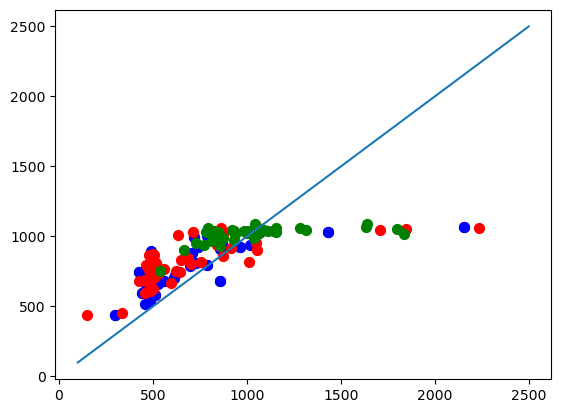

In [19]:

'''Prediction using the best model'''
predict_labels_a=[]
predict_labels_b=[]
predict_labels_train=[]
predict_labels_val = []
model.eval()
with torch.no_grad():
    predict_labels_a.append(model(input_test_a).data.numpy())
    predict_labels_b.append(model(input_test_b).data.numpy())
    
    predict_labels_train.append(model(input_train).data.numpy())   
    predict_labels_val.append(model(input_val).data.numpy())      


actual_label_arr_train=np.round(np.asarray(train_labels*max_label).reshape(-1,1))  
predict_label_arr_train=np.round(np.asarray(predict_labels_train).reshape(-1,1)*max_label)


actual_label_arr_val=np.round(np.asarray(val_labels*max_label).reshape(-1,1))   
predict_label_arr_val=np.round(np.asarray(predict_labels_val).reshape(-1,1)*max_label)


actual_label_arr_a=np.round(np.asarray(test_cycle_life_a*max_label).reshape(-1,1))   
predict_label_arr_a=np.round(np.asarray(predict_labels_a).reshape(-1,1)*max_label)


actual_label_arr_b=np.round(np.asarray(test_cycle_life_b * max_label).reshape(-1,1))   
predict_label_arr_b=np.round(np.asarray(predict_labels_b).reshape(-1,1)*max_label)


'''Plot the predicted cycle lives'''
plt.scatter(actual_label_arr_train, predict_label_arr_train,s=50,c='k')
plt.scatter(actual_label_arr_val, predict_label_arr_val,s=50,c='b')
plt.scatter(actual_label_arr_a, predict_label_arr_a,s=50,c='r')
plt.scatter(actual_label_arr_b, predict_label_arr_b,s=50,c='g')
plt.plot([100,2500],[100,2500])


'''Evaluation metrics'''
mpe_a=np.mean(np.abs(predict_label_arr_a-actual_label_arr_a)/actual_label_arr_a)
mpe_b=np.mean(np.abs(predict_label_arr_b-actual_label_arr_b)/actual_label_arr_b)
mpe_train = np.mean(np.abs(predict_label_arr_train-actual_label_arr_train)/actual_label_arr_train)
mpe_val = np.mean(np.abs(predict_label_arr_val-actual_label_arr_val)/actual_label_arr_val)


rmse_a=np.sqrt(np.mean((predict_label_arr_a-actual_label_arr_a)**2))
rmse_b=np.sqrt(np.mean((predict_label_arr_b-actual_label_arr_b)**2))
rmse_train=np.sqrt(np.mean((predict_label_arr_train-actual_label_arr_train)**2))
rmse_val=np.sqrt(np.mean((predict_label_arr_val-actual_label_arr_val)**2))


print ('mpe_train:',mpe_train)
print ('mpe_val:',mpe_val)
print ('mpe_a:',mpe_a)
print ('mpe_b:',mpe_b)

print ('rmse_train:', rmse_train)
print ('rmse_val:', rmse_val)
print ('rmse_a:', rmse_a)
print ('rmse_b:', rmse_b)

In [20]:
from sklearn.metrics import r2_score
r2_a = r2_score(actual_label_arr_a, predict_label_arr_a)
r2_b = r2_score(actual_label_arr_b, predict_label_arr_b)
r2_train = r2_score(actual_label_arr_train, predict_label_arr_train)
r2_val = r2_score(actual_label_arr_val, predict_label_arr_val)

print('r2_train:', r2_train)
print('r2_val:', r2_val)
print('r2_a:', r2_a)
print('r2_b:', r2_b)

r2_train: 0.37430518865585327
r2_val: 0.328583300113678
r2_a: 0.3304816952119657
r2_b: 0.1727084187753034
